# **KoBERT Model with fine tuning**

 - 1번분석, 발화 내용 기반 보이스피싱 판별

In [1]:
# # 원본 https://github.com/SKTBrain/KoBERT에 나와있는 using pytorch 코드
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [2]:
# # RUN
# 필요 import 문 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np  # 'ersion : '1.23.5'
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/anaconda/envs/mldl_torch/lib/python3.8/site-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [3]:
# # 원본 https://github.com/SKTBrain/KoBERT에 나와있는 using pytorch 코드
# from kobert import get_tokenizer
# from kobert import get_pytorch_kobert_model

In [4]:
# # 원본 https://github.com/SKTBrain/KoBERT에 나와있는 using pytorch 코드
# bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

## HuggingFace 우회

In [5]:
# # RUN
# ModuleNotFoundError: No module named 'kobert'로 인한 허깅페이스 우회
# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [6]:
# # RUN
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

In [7]:
# # RUN
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

In [8]:
# RUN
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2023-08-15 15:21:34.125512: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 15:21:34.166291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 15:21:34.166897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 15:21:35.104007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# # RUN
# # 그래픽 카드 사용
print('torch version: {}'.format(torch.__version__))

if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

torch version: 1.10.1+cu102
현재 가상환경 GPU 사용 가능상태


In [10]:
# 사용하는 Graffic card 이름 확인
torch.cuda.is_available()
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080'

In [11]:
# GPU 용량 확인
# Get the current memory usage (in bytes)
allocated = torch.cuda.memory_allocated(device)
reserved = torch.cuda.memory_reserved(device)

# Convert to MB
allocated_mb = allocated / 1024 / 1024
reserved_mb = reserved / 1024 / 1024

print(f'Allocated memory: {allocated_mb:.2f} MB')
print(f'Reserved memory: {reserved_mb:.2f} MB')

Allocated memory: 0.00 MB
Reserved memory: 0.00 MB


### Loading Data and preprocessing

In [12]:
import os
os.getcwd()

'/KITA_Project'

In [13]:
# 데이터 파일 경로
file_path_data= "/KITA_Project/text_data_shuffled.csv"   # 필요에 따라 파일 경로 변경

df_text = pd.read_csv(file_path_data, encoding='utf-8')
df_text.head()


,label,Sentence
0,councel,어플에서 가능합니다.
1,councel,"네, 맞습니다."
2,voice_phising,그것만 하시면 어차피 반복 업무예요.
3,voice_phising,다른 은행권 계좌가 도예가 될 가능성이 높다는 거예요.
4,voice_phising,그래서 묻는 거예요.


In [14]:
# label 확인

df_text['label'].unique()

array(['councel', 'voice_phising'], dtype=object)

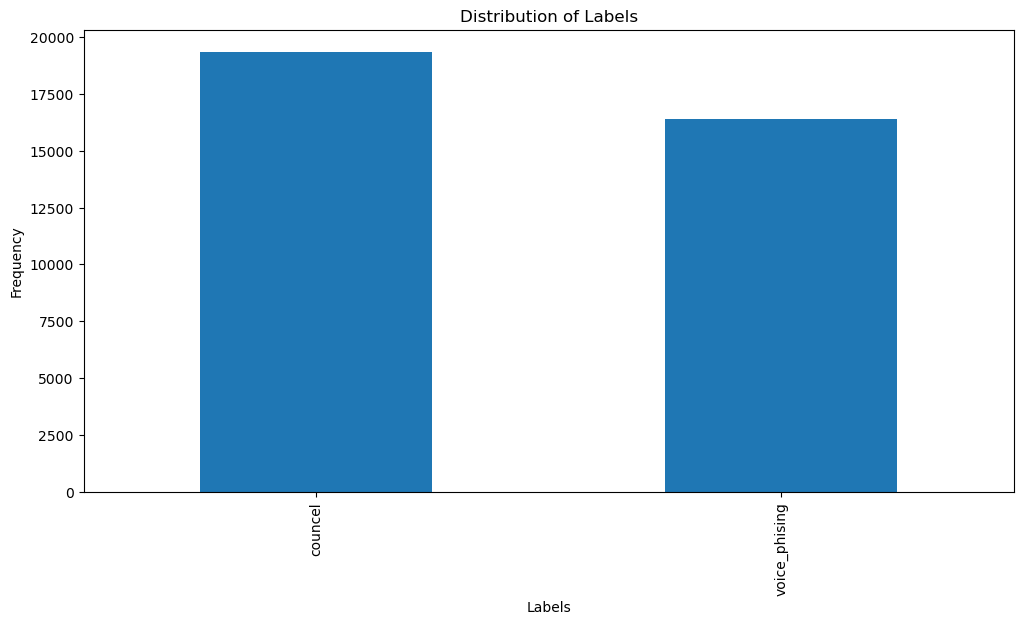

In [15]:
# counsel, voice phishing label 분포도 확인

label_counts = df_text['label'].value_counts()

plt.figure(figsize=(12,6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()


In [16]:
# 레이블 인코딩

df_text.loc[(df_text['label'] == "voice_phising"), 'label'] = 0  # voice phishing → 0
df_text.loc[(df_text['label'] == "councel"), 'label'] = 1  # councel → 1

In [17]:
# text, label 형식의 데이터 list로 만들어주기

data_list= []
for q, label in zip(df_text['Sentence'], df_text['label'])  :
    data = []
    data.append(q)
    data.append(str(label))
    data_list.append(data)
    
print(len(data_list))
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[-1])

35759
['어플에서 가능합니다.', '1']
['이용권에 따라 다릅니다.', '1']
['혹시 피해자라는 걸 지금처럼만 말씀하시면 되고요.', '0']
['그러면 지금 스마트 뱅킹이나 인터넷 뱅킹을 사용하고 계신 건가요?', '0']


### Data Splitting

In [18]:
# Split data into training, validation, and testing sets
# Assuming data_list is your full data
dataset_train, dataset_temp = train_test_split(data_list, test_size=0.2, random_state=42, shuffle=True)
dataset_valid, dataset_test = train_test_split(dataset_temp, test_size=0.2, random_state=42, shuffle=True)
print(len(dataset_train))
print(len(dataset_valid))
print(len(dataset_test))


28607
5721
1431


In [19]:
print(dataset_train[0])
print(dataset_train[5000])
print(dataset_train[10000])
print(dataset_train[20000])
print(dataset_train[25000])

['휴대폰 번호 말씀해 주세요.', '1']
['노원들은 국민은행 안 쓰는데.', '0']
['고객님도 그 부분은 이해 좀 해 주세요, 형님, 저희가 전화상으로만 대출 진행을 하기 때문에 요즘에 은행을 사칭하는 곳이 너무 많지 않습니까, 그런 부분 때문에 저희도 요금 많이 얻어먹습니다, 솔직하게.', '0']
['또는 제가 직원을 그쪽으로 보낼게요.', '0']
['네, 그렇습니다. 고객님.', '1']


In [20]:
print(dataset_valid[0])
print(dataset_valid[2000])
print(dataset_valid[3000])
print(dataset_valid[3500])
print(dataset_valid[4500])

['충청도 경산으로 되어 있어요.', '0']
['네. 맞습니다.', '1']
['궁금한 게 통장을 개설할 때 주민등록증하고 주민등록증하고 왜 본인이 같은 서울 영등포구 문래동 물래 지점에서 농협과 신한의 통장 결산하신 적 있습니까?', '0']
['메모하고 계셨습니까?', '0']
['네, 쿠폰은 같이 드립니다. 단 삼 단계는 현재 재고가 다 소진되어 있습니다.', '1']


In [21]:
print(dataset_test[0])
print(dataset_test[1000])
print(dataset_test[1200])
print(dataset_test[1250])
print(dataset_test[1400])

['아, 네 가능합니다.', '1']
['오천 원입니다.', '1']
['선생님께 안내 의무가 있는 걸로 알고 있는데요. 지금 한번 확인해 보겠습니다.', '1']
['안녕하세요.', '1']
['저희 농협 대출 나가면 그거 가지고 친구분한테 빌렸던 거 갚아주면 되는 거니까요.', '0']


In [22]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, vocab, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [23]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 500
learning_rate =  5e-5

In [24]:
# Define your datasets
dataset_train = BERTDataset(dataset_train, 0, 1, tokenizer, max_len, vocab, True, False)
dataset_valid = BERTDataset(dataset_valid, 0, 1, tokenizer, max_len, vocab, True, False)
dataset_test = BERTDataset(dataset_test, 0, 1, tokenizer, max_len, vocab, True, False)

In [25]:
dataset_train[0]

(array([   2, 5194,  517, 6330, 1961, 7848,  517, 7282,   54,    3,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(10, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [26]:
dataset_valid[0]

(array([   2, 4597, 5859,  953, 6516, 7078, 1767, 3868, 6999,   54,    3,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(11, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [27]:
dataset_test[0]

(array([   2, 3093,   46, 1469,  737, 7843,   54,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(8, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [28]:
# Define your dataloaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=5)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=5)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=5)

In [29]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [30]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [31]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [32]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [33]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.valid_score_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, valid_score, model):
        score = -valid_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(valid_score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(valid_score, model)
            self.counter = 0

    def save_checkpoint(self, valid_score, model):
        if self.verbose:
            self.trace_func(f'Validation score decreased ({self.valid_score_min:.6f} --> {valid_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.valid_score_min = valid_score

### Model train

In [34]:
# Initialize lists for storing history
train_history = []
valid_history = []
test_history = []
loss_history = []
valid_loss_history = []
test_loss_history = []

# Initialize early_stopping object
early_stopping = EarlyStopping(patience=3, verbose=True, path='vp_text_classification_model.pt')

best_valid_acc = 0.0

# Training loop
for e in range(num_epochs):
    train_acc = 0.0
    train_loss = 0.0
    valid_acc = 0.0
    valid_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0
    model.train()  # Set the model to training mode

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to the configured device
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)  # Forward pass

        loss = loss_fn(out, label)  # Compute the loss
        loss.backward()  # Perform backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip gradients
        optimizer.step()  # Update weights
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)  # Calculate accuracy

        if batch_id % log_interval == 0:
            print(f"epoch {e+1} batch id {batch_id+1} loss {loss.item()} train acc {train_acc / (batch_id+1)}")
            train_history.append(train_acc / (batch_id+1))  # Update training history
            loss_history.append(loss.item())  # Update loss history

    print(f"epoch {e+1} train acc {train_acc / (len(train_dataloader))}")
    train_loss /= len(train_dataloader)

    model.eval()  # Set the model to evaluation mode
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids)  # Forward pass
        loss = loss_fn(out, label)
        valid_loss += loss.item()
        valid_acc += calc_accuracy(out, label)  # Calculate accuracy

    print(f"epoch {e+1} valid acc {valid_acc / (len(valid_dataloader))}")
    valid_history.append(valid_acc / (len(valid_dataloader)))  # Update validation history
    valid_loss /= len(valid_dataloader)
    valid_loss_history.append(valid_loss)

    # If the validation accuracy of this epoch is better than before, save the model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), f'vp_text_classification_model_{e+1}.pt')

    # Early stopping
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

  0%|          | 0/447 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.8055591583251953 train acc 0.40625
epoch 1 train acc 0.9018800379958098


  0%|          | 0/90 [00:00<?, ?it/s]

epoch 1 valid acc 0.9748263888888888
Validation score decreased (inf --> 0.081193).  Saving model ...


  0%|          | 0/447 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.03668553754687309 train acc 0.984375
epoch 2 train acc 0.9845841766982707


  0%|          | 0/90 [00:00<?, ?it/s]

epoch 2 valid acc 0.9865347222222222
Validation score decreased (0.081193 --> 0.053727).  Saving model ...


  0%|          | 0/447 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.017573675140738487 train acc 0.984375
epoch 3 train acc 0.9928341722595079


  0%|          | 0/90 [00:00<?, ?it/s]

epoch 3 valid acc 0.9897569444444444
Validation score decreased (0.053727 --> 0.039542).  Saving model ...


  0%|          | 0/447 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0023181792348623276 train acc 1.0
epoch 4 train acc 0.9955950827385391


  0%|          | 0/90 [00:00<?, ?it/s]

epoch 4 valid acc 0.9902777777777778
EarlyStopping counter: 1 out of 3


  0%|          | 0/447 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.0004904699744656682 train acc 1.0
epoch 5 train acc 0.9977978187919463


  0%|          | 0/90 [00:00<?, ?it/s]

epoch 5 valid acc 0.9895833333333334
EarlyStopping counter: 2 out of 3


  0%|          | 0/447 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.0002618173020891845 train acc 1.0
epoch 6 train acc 0.9988814317673378


  0%|          | 0/90 [00:00<?, ?it/s]

epoch 6 valid acc 0.9878472222222222
EarlyStopping counter: 3 out of 3
Early stopping


### Final Evaluation

In [35]:
# Finally, your testing code will be the same as before
model.eval()  # Set the model to evaluation mode
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length.to(device)
    label = label.long().to(device)

    with torch.no_grad():
        out = model(token_ids, valid_length, segment_ids)  # Forward pass
    loss = loss_fn(out, label)
    test_loss += loss.item()
    test_acc += calc_accuracy(out, label)  # Calculate accuracy

print(f"test acc {test_acc / (len(test_dataloader))}")
test_history.append(test_acc / (len(test_dataloader)))  # Update test history
test_loss /= len(test_dataloader)
test_loss_history.append(test_loss)



  0%|          | 0/23 [00:00<?, ?it/s]

test acc 0.9898097826086957


### Plotting training, validation data's Accuracy and Loss

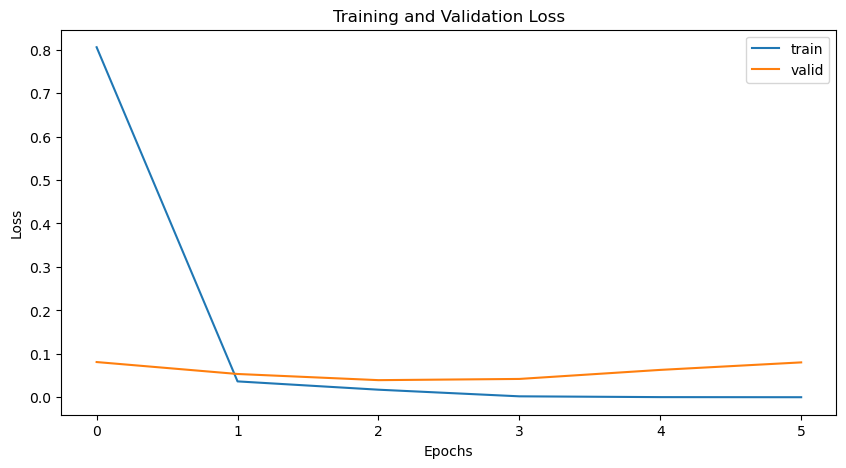

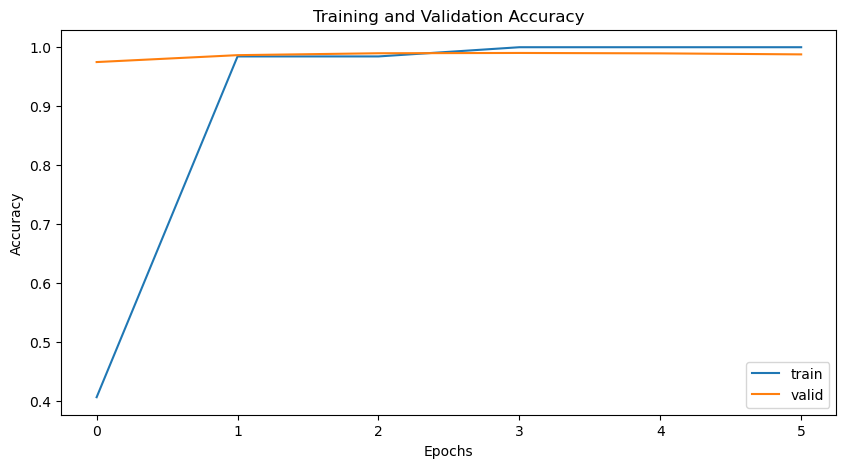

In [36]:
# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(loss_history, label="train")
plt.plot(valid_loss_history, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_history, label="train")
plt.plot(valid_history, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model Load & test evaluation

In [37]:
# Load the best model
model_path = 'vp_text_classification_model.pt'  # adjust the path if needed
model.load_state_dict(torch.load(model_path))

# Initialize variables
test_acc = 0.0
test_loss = 0.0

# Set the model to evaluation mode
model.eval()

# Loop over test data
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length.to(device)
    label = label.long().to(device)

    # Make predictions
    with torch.no_grad():
        out = model(token_ids, valid_length, segment_ids)

    # Compute loss and accuracy
    loss = loss_fn(out, label)
    test_loss += loss.item()
    test_acc += calc_accuracy(out, label)

# Compute average test loss and accuracy
test_acc /= len(test_dataloader)
test_loss /= len(test_dataloader)

# Print results
print(f"test acc {test_acc}")
print(f"test loss {test_loss}")


  0%|          | 0/23 [00:00<?, ?it/s]

test acc 0.9870923913043478
test loss 0.04845100545334508
